In [1]:
!pip install openpyxl -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow # needed for importing dataframes
import warnings

from time import time

# decomposition libs
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

warnings.filterwarnings('ignore') # silence warnings

sel_zone = 'IT_NORD' # select the zone to produce the input for

register_matplotlib_converters()
sns.set_style("darkgrid")

# setup font sizes for images
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18


# Extracting all datasets

### Actuals dataset

In [3]:
years = [2022,2023,2024] # selection of years
df_actuals = pd.DataFrame()

for year in years:
    
    filename = f"lcpb_files/{year}_actuals.zst"
    df = pd.read_parquet(filename)  # this reads .zst files efficiently
    df = df[df['zone'] == sel_zone]
    df_actuals = pd.concat([df_actuals, df])
# making a growing time param
time = []
for i in range(np.shape(df_actuals)[0]):
    time.append(i)
df_actuals['time'] = np.array(time) / max(time)
    
df_actuals


,zone,solar,wind,hydro,generation,load,time
date_time,,,,,,,
2022-01-01 00:00:00+00:00,IT_NORD,0.0,2.0,1110.0,6894.0,10583.0,0.000000
2022-01-01 01:00:00+00:00,IT_NORD,0.0,22.0,1063.0,6297.0,10054.0,0.000038
2022-01-01 02:00:00+00:00,IT_NORD,0.0,22.0,1057.0,5373.0,9573.0,0.000076
2022-01-01 03:00:00+00:00,IT_NORD,0.0,22.0,1089.0,4963.0,9402.0,0.000114
2022-01-01 04:00:00+00:00,IT_NORD,0.0,22.0,1053.0,5405.0,9689.0,0.000152
...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,IT_NORD,0.0,56.0,1216.0,10158.0,11958.0,0.999848
2024-12-31 23:00:00+00:00,IT_NORD,0.0,8.0,218.0,2110.0,11528.0,0.999886
2024-12-31 23:15:00+00:00,IT_NORD,0.0,8.0,214.0,2095.0,11695.0,0.999924


### Resampling (every hour)
to remove problems connected with data acquisition every tot time

,date_time,solar,wind,hydro,generation,load,ratio
0,2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.105074
1,2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.107917
2,2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.112713
3,2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.118166
4,2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.110951
...,...,...,...,...,...,...,...
26299,2024-12-31 19:00:00+00:00,0.0,256.0,7260.0,51760.0,59120.0,0.127131
26300,2024-12-31 20:00:00+00:00,0.0,244.0,6100.0,45612.0,54604.0,0.116182
26301,2024-12-31 21:00:00+00:00,0.0,224.0,5292.0,41680.0,51008.0,0.108140
26302,2024-12-31 22:00:00+00:00,0.0,224.0,4864.0,40632.0,47832.0,0.106372


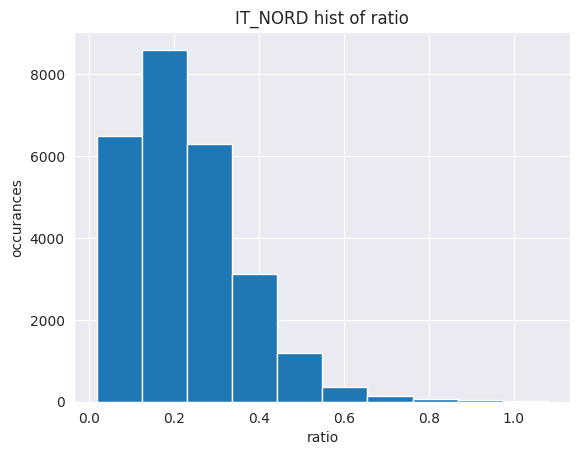

In [4]:
df_actuals = df_actuals.resample('1h').agg({'solar': 'sum',
                                        'wind': 'sum',
                                        'hydro': 'sum',
                                        'generation':'sum',
                                        'load':'sum'}) 
df_actuals = df_actuals.reset_index()
df_actuals['ratio'] = (df_actuals['solar'] + df_actuals['wind'] + df_actuals['hydro'] ) / df_actuals['load']
plt.hist(df_actuals['ratio'])
plt.xlabel('ratio')
plt.ylabel('occurances')
plt.title(f'{sel_zone} hist of ratio')
df_actuals

In [5]:
#including time variable (for detrending fits)
df_actuals['time'] = np.linspace(0,1,len(df_actuals['date_time']))
df_actuals

,date_time,solar,wind,hydro,generation,load,ratio,time
0,2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.105074,0.000000
1,2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.107917,0.000038
2,2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.112713,0.000076
3,2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.118166,0.000114
4,2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.110951,0.000152
...,...,...,...,...,...,...,...,...
26299,2024-12-31 19:00:00+00:00,0.0,256.0,7260.0,51760.0,59120.0,0.127131,0.999848
26300,2024-12-31 20:00:00+00:00,0.0,244.0,6100.0,45612.0,54604.0,0.116182,0.999886
26301,2024-12-31 21:00:00+00:00,0.0,224.0,5292.0,41680.0,51008.0,0.108140,0.999924
26302,2024-12-31 22:00:00+00:00,0.0,224.0,4864.0,40632.0,47832.0,0.106372,0.999962


## Solar production feature

In [6]:
installation_24 = pd.read_excel('lcpb_files/installazioni_mensili_2024.xlsx')
solar_installation_24 = installation_24[installation_24['Fonte']=='Solare']

In [7]:
df_solar_nord_24 = solar_installation_24[solar_installation_24['Zona mercato']=='Nord']
df_solar_nord_24= df_solar_nord_24.sort_values(by='Mese', ascending=True)
df_solar_nord_24['time']= 1.0/3*df_solar_nord_24['Mese']/12 + 2.0/3
df_solar_nord_24 = (df_solar_nord_24.groupby(['time','Anno', 'Mese'], as_index=False)['Potenza attiva nominale (MW)'].sum().sort_values(by='Mese'))
df_solar_nord_24['Solare_installato']= df_solar_nord_24['Potenza attiva nominale (MW)'].cumsum() # cumulative power installed up to that month of 2024

In [8]:
df_solar = pd.read_excel('lcpb_files/solare_GSE_2021_2023.xlsx') 
nord_regions = ["Valle d'Aosta", 'Piemonte', 'Liguria','Lombardia', 'Veneto', 'Friuli Venezia Giulia', 'Emilia Romagna','Provincia Autonoma di Bolzano',
'Provincia Autonoma di Trento']
df_solar_nord = df_solar[df_solar['Regione'].isin(nord_regions)]
solar = df_solar_nord.groupby(['Anno'])['Potenza installata (MW)'].agg(Solare_installato ='sum')
df_solar_nord = df_solar_nord.merge(solar, on = ['Anno'], how='left')
df_solar_nord['time']= (df_solar_nord['Anno']-2021)*1.0/3
df_solar_nord= df_solar_nord.drop_duplicates(subset=['Anno', 'time','Solare_installato'])
df_solar_nord= df_solar_nord.drop('Regione',axis=1)

df_solar_nord_24['Solare_installato']=  df_solar_nord_24['Solare_installato'] + df_solar_nord['Solare_installato'].iloc[-1] # power installed at 2023 + cumulative power installed during 2024

df_solar_nord = df_solar_nord[['time', 'Anno', 'Solare_installato']]  # from 2021–2023
df_solar_nord_24 = df_solar_nord_24[['time', 'Anno', 'Solare_installato']]  # from 2024

# concatenate
df_solar_nord = pd.concat([df_solar_nord, df_solar_nord_24], ignore_index=True)
df_solar_nord

,time,Anno,Solare_installato
0,0.000000,2021,10169.91000
1,0.333333,2022,11493.82000
2,0.666667,2023,14563.00000
3,0.694444,2024,14870.46006
4,0.722222,2024,15141.16709
5,0.750000,2024,15361.78327
6,0.777778,2024,15548.59468
7,0.805556,2024,15775.34586
8,0.833333,2024,15976.35703
9,0.861111,2024,16178.24793


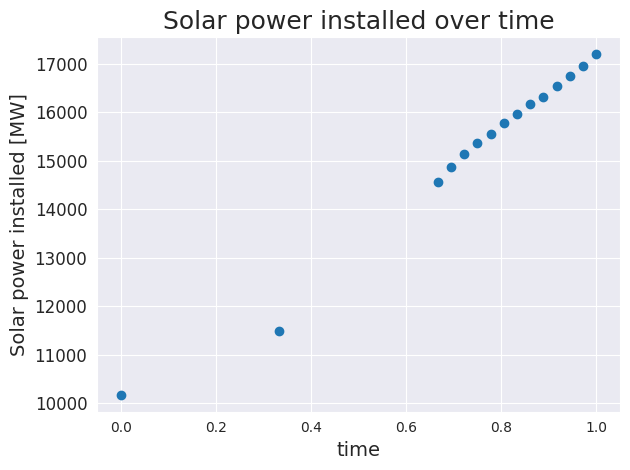

In [9]:
plt.scatter(df_solar_nord['time'],df_solar_nord['Solare_installato'])
xtick = df_solar_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Solar power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Solar power installed over time', fontsize = titlefontsize)
plt.tight_layout()

plt.show()



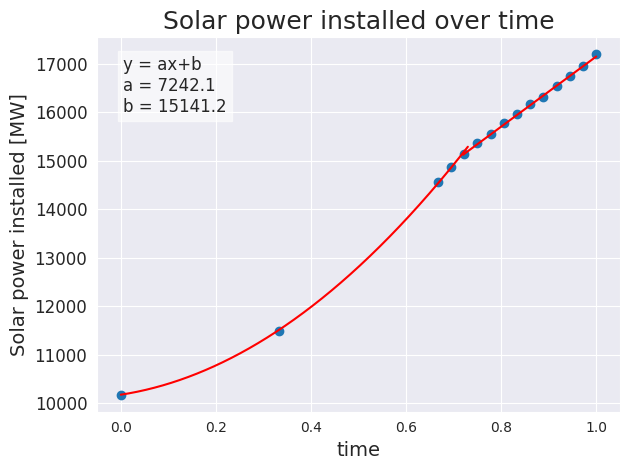

In [10]:
# parabolic fit
c_parab = df_solar_nord[df_solar_nord['Anno']==2021]['Solare_installato'].values[0]
y_parab = np.array(df_solar_nord[df_solar_nord['time'] < 0.73]['Solare_installato'])- c_parab
a_parab,b_parab = np.polyfit(np.array(df_solar_nord[df_solar_nord['time'] < 0.73]['time']), np.array(y_parab), 2)[0:2]
parab_fit = df_actuals['time']**2*a_parab + b_parab*df_actuals['time'] + c_parab

# linear fit (2024)
b_linear = df_solar_nord.iloc[4]['Solare_installato']
y_linear = np.array(df_solar_nord[df_solar_nord['time'] > 0.72]['Solare_installato']) - b_linear
a_linear = np.polyfit(np.array(df_solar_nord[df_solar_nord['time'] > 0.72]['time']), np.array(y_linear), 1)[0]
linear_fit = (df_actuals[df_actuals['time'] > 0.72]['time']-0.722222)*a_linear + b_linear

# plot logic
plt.scatter(df_solar_nord['time'],df_solar_nord['Solare_installato'])
plt.plot(df_actuals[df_actuals['time'] > 0.72]['time'],linear_fit,color='red',label='Linear fit')
x=df_actuals[df_actuals['time'] < 0.73]['time']
plt.plot(x,parab_fit[:len(x)],color='red',label='Parabolic fit')
xtick = df_solar_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Solar power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Solar power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax+b \na = {round(a_linear,1)}\nb = {round(b_linear,1)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()



In [11]:
# saving installed information
df_actuals['solar_installed']=0.
df_actuals.loc[df_actuals['time']<0.7222,'solar_installed']=parab_fit
df_actuals.loc[df_actuals['time']>0.7221,'solar_installed']=linear_fit
df_actuals


,date_time,solar,wind,hydro,generation,load,ratio,time,solar_installed
0,2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.105074,0.000000,10169.910000
1,2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.107917,0.000038,10169.967563
2,2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.112713,0.000076,10170.025148
3,2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.118166,0.000114,10170.082755
4,2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.110951,0.000152,10170.140383
...,...,...,...,...,...,...,...,...,...
26299,2024-12-31 19:00:00+00:00,0.0,256.0,7260.0,51760.0,59120.0,0.127131,0.999848,17151.767261
26300,2024-12-31 20:00:00+00:00,0.0,244.0,6100.0,45612.0,54604.0,0.116182,0.999886,17152.042595
26301,2024-12-31 21:00:00+00:00,0.0,224.0,5292.0,41680.0,51008.0,0.108140,0.999924,17152.317930
26302,2024-12-31 22:00:00+00:00,0.0,224.0,4864.0,40632.0,47832.0,0.106372,0.999962,17152.593264


### Removing outliers

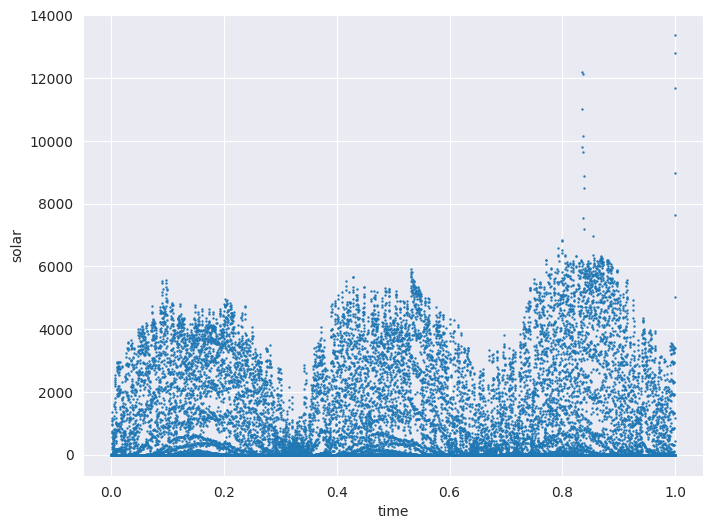

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=[8,6])
feature = 'solar'
ax.scatter(df_actuals['time'], df_actuals[feature], s = 0.5)

ax.set_xlabel('time')
ax.set_ylabel(feature)
plt.show()


In [13]:
df_actuals = df_actuals[df_actuals[feature]<7000]
df_actuals

,date_time,solar,wind,hydro,generation,load,ratio,time,solar_installed
0,2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.105074,0.000000,10169.910000
1,2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.107917,0.000038,10169.967563
2,2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.112713,0.000076,10170.025148
3,2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.118166,0.000114,10170.082755
4,2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.110951,0.000152,10170.140383
...,...,...,...,...,...,...,...,...,...
26299,2024-12-31 19:00:00+00:00,0.0,256.0,7260.0,51760.0,59120.0,0.127131,0.999848,17151.767261
26300,2024-12-31 20:00:00+00:00,0.0,244.0,6100.0,45612.0,54604.0,0.116182,0.999886,17152.042595
26301,2024-12-31 21:00:00+00:00,0.0,224.0,5292.0,41680.0,51008.0,0.108140,0.999924,17152.317930
26302,2024-12-31 22:00:00+00:00,0.0,224.0,4864.0,40632.0,47832.0,0.106372,0.999962,17152.593264


# Wind (CAREFUL ON ZONES)

## REMOVING OFFSET

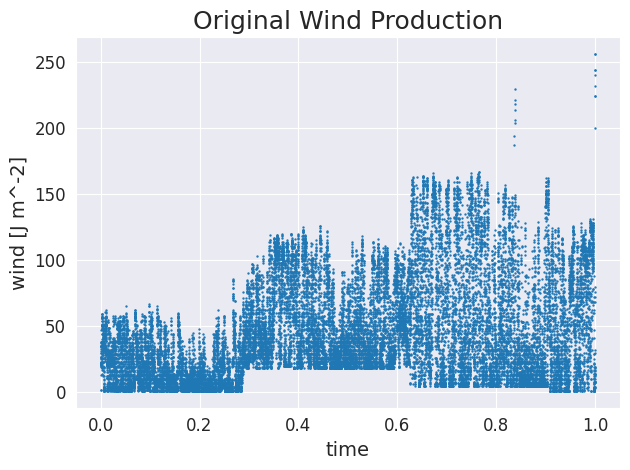

In [14]:
feature = 'wind'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
plt.title('Original Wind Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig(f'figures/{feature}_plot_before.png')
plt.show()

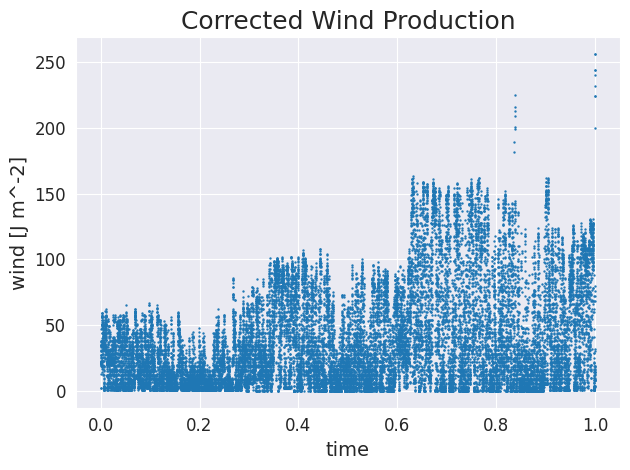

In [15]:
df_actuals[(df_actuals['time'] >= 0.32) & (df_actuals['time'] <= 0.6)].min()

df_actuals.loc[
    (df_actuals['time'] >= 0.29) & (df_actuals['time'] <= 0.62), 'wind'
] = df_actuals.loc[
    (df_actuals['time'] >= 0.29) & (df_actuals['time'] <= 0.62), 'wind'
] - 18.0
df_actuals[(df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896)].min()
df_actuals.loc[
    (df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896), 'wind'
] = df_actuals.loc[
    (df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896), 'wind'
] - 5.0

feature = 'wind'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
plt.title('Corrected Wind Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig(f'figures/{feature}_plot_after.png')
plt.show()


## DETRENDING CODE

In [16]:
df_wind = pd.read_csv('lcpb_files/eolico_GSE_2021_2023.csv',delimiter=';') 
nord_regions = ["Valle d'Aosta", 'Piemonte', 'Liguria','Lombardia', 'Veneto', 'Friuli Venezia Giulia', 'Emilia Romagna','Provincia Autonoma di Bolzano',
'Provincia Autonoma di Trento']
df_wind_nord = df_wind[df_wind['Regione'].isin(nord_regions)]
wind = df_wind_nord.groupby(['Anno'])['Valore'].agg(Eolico_installato ='sum')
df_wind_nord = df_wind_nord.merge(wind, on = ['Anno'], how='left')
df_wind_nord['time']= (df_wind_nord['Anno']-2021)*1.0/3
df_wind_nord= df_wind_nord.drop_duplicates(subset=['Anno', 'time','Eolico_installato'])
df_wind_nord= df_wind_nord.drop('Regione',axis=1)
df_wind_nord


,Valore,Anno,Eolico_installato,time
0,19,2021,167,0.000000
7,19,2022,199,0.333333
14,19,2023,201,0.666667


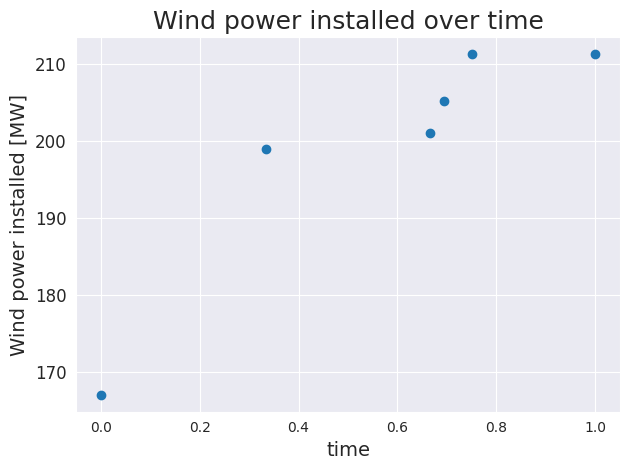

,time,Anno,Eolico_installato
0,0.000000,2021,167.0000
1,0.333333,2022,199.0000
2,0.666667,2023,201.0000
3,0.694444,2024,205.2600
4,0.750000,2024,211.2600
5,1.000000,2024,211.2708


In [17]:
wind_installation_24 = installation_24[installation_24['Fonte']=='Eolico'] # GSE wind power installation 2024
df_wind_nord_24 = wind_installation_24[wind_installation_24['Zona mercato']=='Nord']
df_wind_nord_24 = df_wind_nord_24.sort_values(by='Mese', ascending=True)
df_wind_nord_24['time']= 1.0/3*df_wind_nord_24['Mese']/12 + 2.0/3
df_wind_nord_24 = (df_wind_nord_24.groupby(['time','Anno', 'Mese'], as_index=False)['Potenza attiva nominale (MW)'].sum().sort_values(by='Mese'))
df_wind_nord_24['Eolico_installato']= df_wind_nord_24['Potenza attiva nominale (MW)'].cumsum() #
df_wind_nord_24['Eolico_installato']=  df_wind_nord_24['Eolico_installato'] + df_wind_nord['Eolico_installato'].iloc[-1]
df_wind_nord = df_wind_nord[['time', 'Anno', 'Eolico_installato']]  # from 2021–2023
df_wind_nord_24 = df_wind_nord_24[['time', 'Anno', 'Eolico_installato']]  # from 2024
df_wind_nord = pd.concat([df_wind_nord, df_wind_nord_24], ignore_index=True)

# drop duplicates
df_wind_nord = df_wind_nord.drop_duplicates()

# plot snippet
plt.scatter(df_wind_nord['time'],df_wind_nord['Eolico_installato'])
xtick = df_wind_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Wind power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Wind power installed over time', fontsize = titlefontsize)
plt.tight_layout()

plt.show()
df_wind_nord


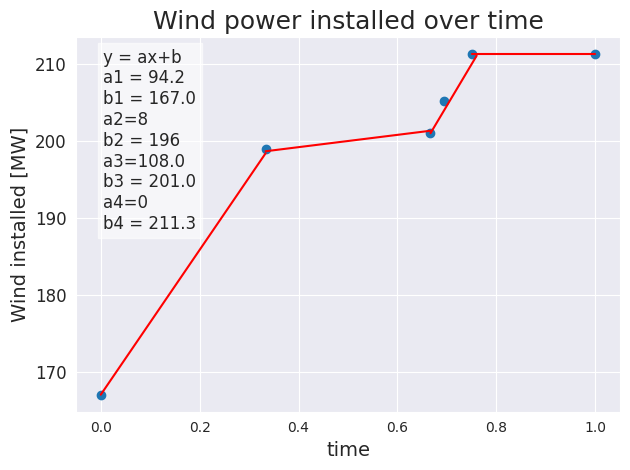

In [18]:
# parabolic fit
c_parab = df_wind_nord[df_wind_nord['Anno']==2021]['Eolico_installato'].values[0]
y_parab = np.array(df_wind_nord[df_wind_nord['time'] < 0.6668]['Eolico_installato'])- c_parab
a_parab,b_parab = np.polyfit(np.array(df_wind_nord[df_wind_nord['time'] < 0.6668]['time']), np.array(y_parab), 2)[0:2]
parab_fit = df_actuals['time']**2*a_parab + b_parab*df_actuals['time'] + c_parab
# first linear
b_linear = df_wind_nord.iloc[2]['Eolico_installato']
y_linear = np.array(df_wind_nord[(df_wind_nord['time'] > 0.6667) & (df_wind_nord['time'] < 0.751)]['Eolico_installato']) - b_linear
a_linear = np.polyfit(np.array(df_wind_nord[(df_wind_nord['time'] > 0.6667) & (df_wind_nord['time'] < 0.751)]['time']), np.array(y_linear), 1)[0]
linear_fit = (df_actuals[(df_actuals['time'] > 0.6667) & (df_actuals['time'] < 0.76)]['time'] - 0.666667) * a_linear + b_linear
# second linear
b_linear_1=167.
a_linear_1=94.2

#b_linear_1 = df_wind_nord.iloc[1]['Eolico_installato']
#y_linear_1 = np.array(df_wind_nord[df_wind_nord['time'] < 0.33334]['Eolico_installato']) - b_linear_1
#a_linear_1 = np.polyfit(np.array(df_wind_nord[df_wind_nord['time'] < 0.33334]['time']), y_linear_1, 1)[0]
linear_fit_1 = (df_actuals[df_actuals['time'] < 0.33334]['time'] ) * a_linear_1 + b_linear_1

b_linear_2=196
a_linear_2=8
#b_linear_2 = df_wind_nord.iloc[1]['Eolico_installato']
#y_linear_2 = np.array(df_wind_nord[(df_wind_nord['time'] > 0.33334) & (df_wind_nord['time'] < 0.6667)]['Eolico_installato']) - b_linear_2
#a_linear_2 = np.polyfit(np.array(df_wind_nord[(df_wind_nord['time'] > 0.33334) & (df_wind_nord['time'] < 0.6667)]['time']), y_linear_2, 1)[0]
linear_fit_2 = (df_actuals[(df_actuals['time'] > 0.33334) & (df_actuals['time'] < 0.6667)]['time']) * a_linear_2+ b_linear_2


# saving installation feature
df_actuals['wind_installed']=0.0
df_actuals.loc[df_actuals['time']<0.33334,'wind_installed']=linear_fit_1
df_actuals.loc[(df_actuals['time']>0.33334)&(df_actuals['time']<0.6667),'wind_installed']=linear_fit_2
df_actuals.loc[(df_actuals['time']>0.6667)&(df_actuals['time']<0.753),'wind_installed']=linear_fit
df_actuals.loc[df_actuals['time']>0.752,'wind_installed']=df_wind_nord['Eolico_installato'].iloc[-1]

# plot logic
plt.scatter(df_wind_nord['time'],df_wind_nord['Eolico_installato'])
#plt.plot(df_actuals[df_actuals['time']< 0.6668]['time'],parab_fit,color='red',label='Linear fit 1')
x_1=df_actuals[df_actuals['time'] < 0.333334]['time']
plt.plot(x_1,linear_fit_1[:len(x)],color='red',label='Parabolic fit')
x_2=df_actuals[(df_actuals['time'] > 0.33334) & (df_actuals['time'] < 0.6667)]['time']
plt.plot(x_2,linear_fit_2[:len(x)],color='red',label='Parabolic fit')
plt.plot(df_actuals[(df_actuals['time'] > 0.6667) & (df_actuals['time'] < 0.76)]['time'],linear_fit,color='red',label='Linear fit')
plt.plot([0.751, 1], [211.265, 211.265], color='red', label='Constant')
xtick = df_wind_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Wind installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Wind power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax+b\na1 = {round(a_linear_1,1)}\nb1 = {round(b_linear_1,1)}\na2={round(a_linear_2,1)}\nb2 = {round(b_linear_2,1)}\na3={round(a_linear,1)}\nb3 = {round(b_linear,1)}\na4={round(0,1)}\nb4 = {round(211.265,1)}' 
plt.text(0.05, 0.97, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()






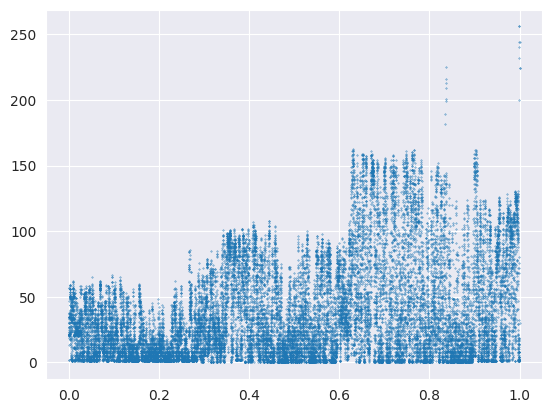

In [19]:
df_actuals
plt.scatter(df_actuals['time'],df_actuals['wind'], s=0.1)

## REMOVING OUTLIERS

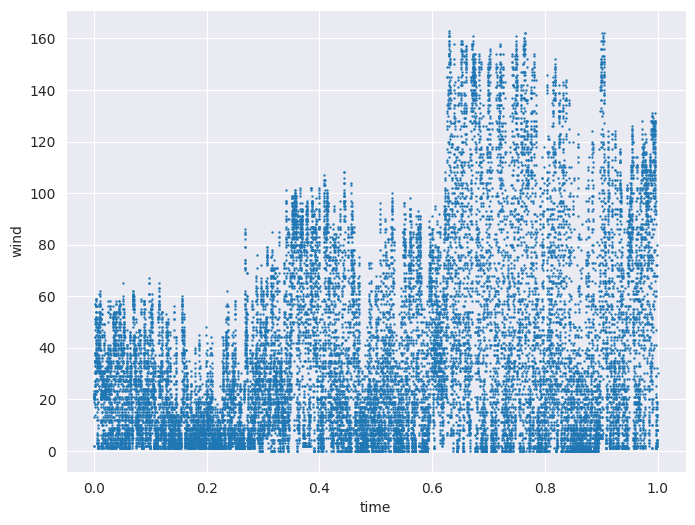

In [20]:
df_actuals = df_actuals[df_actuals['wind']<165]

fig, ax = plt.subplots(nrows=1, figsize=[8,6])
ax.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
ax.set_xlabel('time')
ax.set_ylabel('wind')

plt.show()



# HYDRO (CAREFUL WITH ZONES)

In [21]:
df_hydro = pd.read_excel('lcpb_files/idrico_GSE_2021_2023.xlsx')  # GSE 2021-2023 hydro data
df_hydro_nord = df_hydro[df_hydro['Regione'].isin(nord_regions)]
hydro = df_hydro_nord.groupby(['Anno'])['Idrico'].agg(Idrico_installato ='sum')
df_hydro_nord = df_hydro_nord.merge(hydro, on = ['Anno'], how='left')
df_hydro_nord['time']= (df_hydro_nord['Anno']-2021)*1.0/3
df_hydro_nord= df_hydro_nord.drop_duplicates(subset=['Anno', 'time','Idrico_installato'])
df_hydro_nord= df_hydro_nord.drop('Regione',axis=1)
df_hydro_nord= df_hydro_nord.drop('Idrico',axis=1)
hydro_installation_24 = installation_24[installation_24['Fonte']=='Idroelettrico'] #2024 gse data
df_hydro_nord_24 = hydro_installation_24[hydro_installation_24['Zona mercato']=='Nord']
df_hydro_nord_24 = df_hydro_nord_24.sort_values(by='Mese', ascending=True)
df_hydro_nord_24['time']= 1.0/3*df_hydro_nord_24['Mese']/12 + 2.0/3
df_hydro_nord_24 = (df_hydro_nord_24.groupby(['time','Anno', 'Mese'], as_index=False)['Potenza attiva nominale (MW)'].sum().sort_values(by='Mese'))
df_hydro_nord_24['Idrico_installato']= df_hydro_nord_24['Potenza attiva nominale (MW)'].cumsum() # cumulative power installed up to that month of 2024
df_hydro_nord_24['Idrico_installato']=  df_hydro_nord_24['Idrico_installato'] + 11254 # power installed at 2023 + cumulative power installed during 2024
df_hydro_nord = df_hydro_nord[['time', 'Anno', 'Idrico_installato']]  # from 2021–2023
df_hydro_nord_24 = df_hydro_nord_24[['time', 'Anno', 'Idrico_installato']]  # from 2024
df_hydro_nord = pd.concat([df_hydro_nord, df_hydro_nord_24], ignore_index=True)
df_hydro_nord # complete hydro installation dataframe


,time,Anno,Idrico_installato
0,0.000000,2021,11174.0000
1,0.333333,2022,11217.0000
2,0.666667,2023,11254.0000
3,0.694444,2024,11255.6740
4,0.722222,2024,11255.9090
5,0.750000,2024,11256.7680
6,0.777778,2024,11257.2680
7,0.805556,2024,11259.9180
8,0.833333,2024,11264.3270
9,0.861111,2024,11265.5970


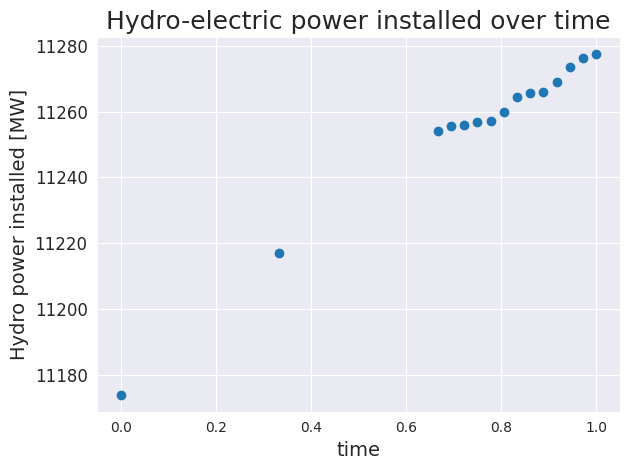

In [22]:
plt.scatter(df_hydro_nord['time'],df_hydro_nord['Idrico_installato'])
xtick = df_wind_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Hydro power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Hydro-electric power installed over time', fontsize = titlefontsize)
plt.tight_layout()

plt.show()


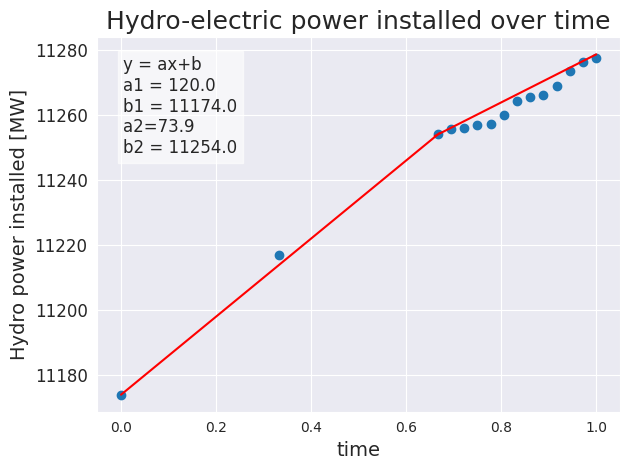

In [23]:
# linear fit 1
b_linear_1 = df_hydro_nord[df_hydro_nord['Anno']==2021]['Idrico_installato'].values[0]
y_linear_1 = np.array(df_hydro_nord[df_hydro_nord['time']< 0.67]['Idrico_installato'])- b_linear_1
a_linear_1 = np.polyfit(np.array(df_hydro_nord[df_hydro_nord['time']< 0.67]['time']), np.array(y_linear_1), 1)[0]
linear_fit_1 = (df_actuals[df_actuals['time']< 0.67]['time'])*a_linear_1 + b_linear_1
# linear fit 2
b_linear_2 = df_hydro_nord.iloc[2]['Idrico_installato']
y_linear_2 = np.array(df_hydro_nord[df_hydro_nord['time']> 0.66]['Idrico_installato'])- b_linear_2
a_linear_2 = np.polyfit(np.array(df_hydro_nord[df_hydro_nord['time']> 0.66]['time']), np.array(y_linear_2), 1)[0]
linear_fit_2 = (df_actuals[df_actuals['time']> 0.66]['time']-0.6666667)*a_linear_2 + b_linear_2
# plot code
plt.scatter(df_hydro_nord['time'],df_hydro_nord['Idrico_installato'])
plt.plot(df_actuals[df_actuals['time']< 0.67]['time'],linear_fit_1,color='red',label='Linear fit 1')
plt.plot(df_actuals[df_actuals['time']> 0.66]['time'],linear_fit_2,color='red',label='Linear fit 2')
xtick = df_hydro_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Hydro power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Hydro-electric power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax+b\na1 = {round(a_linear_1,1)}\nb1 = {round(b_linear_1,1)}\na2={round(a_linear_2,1)}\nb2 = {round(b_linear_2,1)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()




In [24]:
# saving installation feature
df_actuals['hydro_installed']=0.
df_actuals.loc[df_actuals['time']<0.6668,'hydro_installed']=linear_fit_1
df_actuals.loc[df_actuals['time']>0.6667,'hydro_installed']=linear_fit_2


In [25]:
df_actuals

,date_time,solar,wind,hydro,generation,load,ratio,time,solar_installed,wind_installed,hydro_installed
0,2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,0.105074,0.000000,10169.910000,167.000000,11174.000000
1,2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,0.107917,0.000038,10169.967563,167.003581,11174.004562
2,2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,0.112713,0.000076,10170.025148,167.007163,11174.009124
3,2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,0.118166,0.000114,10170.082755,167.010744,11174.013687
4,2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,0.110951,0.000152,10170.140383,167.014325,11174.018249
...,...,...,...,...,...,...,...,...,...,...,...
26285,2024-12-31 05:00:00+00:00,0.0,68.0,5164.0,42620.0,49460.0,0.105782,0.999316,17147.912580,211.270800,11278.575326
26286,2024-12-31 06:00:00+00:00,0.0,72.0,8940.0,52456.0,56540.0,0.159392,0.999354,17148.187914,211.270800,11278.578135
26287,2024-12-31 07:00:00+00:00,1184.0,80.0,9368.0,54156.0,60352.0,0.176166,0.999392,17148.463249,211.270800,11278.580944
26288,2024-12-31 08:00:00+00:00,5016.0,76.0,6356.0,50720.0,60532.0,0.189123,0.999430,17148.738583,211.270800,11278.583753


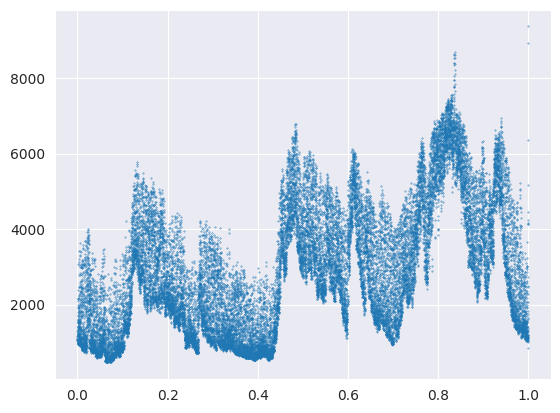

In [26]:
plt.scatter(df_actuals['time'],df_actuals['hydro'],s=0.1)

# Resampling (every 3h)

In [27]:
# resample every 3h
df_actuals = df_actuals.set_index(df_actuals['date_time'])
resampled = df_actuals.resample('3h').agg({'solar_installed': 'mean',
                                        'hydro_installed': 'mean',
                                        'wind_installed': 'mean',
                                        'load':'sum',
                                        'solar':'sum',
                                        'wind':'sum',
                                        'hydro':'sum',
                                        'generation':'sum'}) 
resampled = resampled.reset_index()
resampled

,date_time,solar_installed,hydro_installed,wind_installed,load,solar,wind,hydro,generation
0,2022-01-01 00:00:00+00:00,10169.967570,11174.004562,167.003581,30210.0,0.0,46.0,3230.0,18564.0
1,2022-01-01 03:00:00+00:00,10170.140390,11174.018249,167.014325,29303.0,0.0,65.0,3301.0,16035.0
2,2022-01-01 06:00:00+00:00,10170.313406,11174.031936,167.025069,31940.0,374.0,36.0,4025.0,15267.0
3,2022-01-01 09:00:00+00:00,10170.486619,11174.045622,167.035813,34109.0,2836.0,63.0,3524.0,19553.0
4,2022-01-01 12:00:00+00:00,10170.660027,11174.059309,167.046557,33661.0,1933.0,63.0,3470.0,18016.0
...,...,...,...,...,...,...,...,...,...
8763,2024-12-31 09:00:00+00:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8764,2024-12-31 12:00:00+00:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8765,2024-12-31 15:00:00+00:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8766,2024-12-31 18:00:00+00:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


### Removing NANs

In [28]:
num_rows_with_na = resampled.isna().any(axis=1).sum()
print('found',num_rows_with_na,'lines with NA')
resampled = resampled.dropna()
print('new data shape:',np.shape(resampled))

found 4 lines with NA
new data shape: (8764, 9)


### making the label for classification
(solar + wind + hydro ) / load is our criteria. The classification will be done based on the values that this ratio takes (it varies by zone)

In [29]:
resampled['ratio'] = (resampled['wind'] + resampled['solar'] + resampled['hydro'] ) / resampled['load']
pos = len(np.where(resampled['ratio'] >= 1)[0])
neg = len(np.where(resampled['ratio'] < 1)[0])
print('percentage of positive points in dataset:', pos * 100,'%')


percentage of positive points in dataset: 0 %


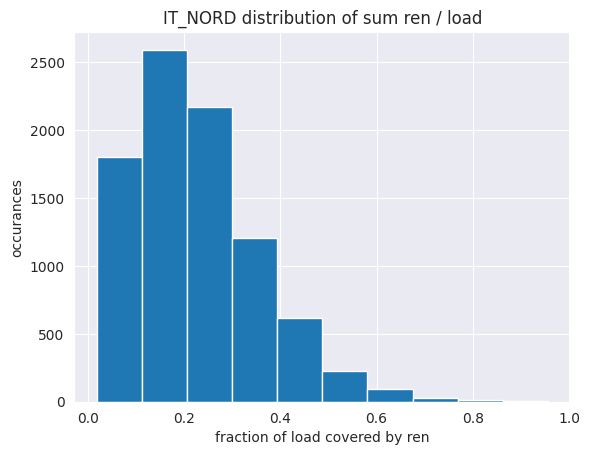

In [30]:
plt.hist(resampled['ratio'])
plt.title(f'{sel_zone} distribution of sum ren / load')
plt.xlabel('fraction of load covered by ren')
plt.ylabel('occurances')
plt.show()

# Feature normalization
normalizing features accordingly to what needed

In [31]:
resampled

,date_time,solar_installed,hydro_installed,wind_installed,load,solar,wind,hydro,generation,ratio
0,2022-01-01 00:00:00+00:00,10169.967570,11174.004562,167.003581,30210.0,0.0,46.0,3230.0,18564.0,0.108441
1,2022-01-01 03:00:00+00:00,10170.140390,11174.018249,167.014325,29303.0,0.0,65.0,3301.0,16035.0,0.114869
2,2022-01-01 06:00:00+00:00,10170.313406,11174.031936,167.025069,31940.0,374.0,36.0,4025.0,15267.0,0.138854
3,2022-01-01 09:00:00+00:00,10170.486619,11174.045622,167.035813,34109.0,2836.0,63.0,3524.0,19553.0,0.188308
4,2022-01-01 12:00:00+00:00,10170.660027,11174.059309,167.046557,33661.0,1933.0,63.0,3470.0,18016.0,0.162384
...,...,...,...,...,...,...,...,...,...,...
8759,2024-12-30 21:00:00+00:00,17145.985239,11278.555665,211.270800,36808.0,0.0,19.0,3893.0,31102.0,0.106281
8760,2024-12-31 00:00:00+00:00,17146.811243,11278.564091,211.270800,120364.0,0.0,16.0,12740.0,90856.0,0.105979
8761,2024-12-31 03:00:00+00:00,17147.637246,11278.572518,211.270800,132516.0,0.0,108.0,13536.0,106388.0,0.102961
8762,2024-12-31 06:00:00+00:00,17148.463249,11278.580944,211.270800,177424.0,6200.0,228.0,24664.0,157332.0,0.175241


In [32]:
# installation is normalized by its max value to preserve information about trend, and keeping it between 0 and 1
resampled['solar_installed'] = resampled['solar_installed'] / max(resampled['solar_installed'])
resampled['wind_installed'] = resampled['wind_installed'] / max(resampled['wind_installed'])
resampled['hydro_installed'] = resampled['hydro_installed'] / max(resampled['hydro_installed'])

# a time parameter between 0 and 1 is added accordingly to the right timestep
time = resampled['date_time'].dt.hour + resampled['date_time'].dt.dayofyear * 24 + (resampled['date_time'].dt.year - 2022) * 24* 365
time = time / max(time)
resampled['time'] = time
resampled



,date_time,solar_installed,hydro_installed,wind_installed,load,solar,wind,hydro,generation,ratio,time
0,2022-01-01 00:00:00+00:00,0.592902,0.990724,0.790472,30210.0,0.0,46.0,3230.0,18564.0,0.108441,0.000912
1,2022-01-01 03:00:00+00:00,0.592912,0.990725,0.790523,29303.0,0.0,65.0,3301.0,16035.0,0.114869,0.001026
2,2022-01-01 06:00:00+00:00,0.592922,0.990726,0.790573,31940.0,374.0,36.0,4025.0,15267.0,0.138854,0.001140
3,2022-01-01 09:00:00+00:00,0.592932,0.990728,0.790624,34109.0,2836.0,63.0,3524.0,19553.0,0.188308,0.001254
4,2022-01-01 12:00:00+00:00,0.592942,0.990729,0.790675,33661.0,1933.0,63.0,3470.0,18016.0,0.162384,0.001368
...,...,...,...,...,...,...,...,...,...,...,...
8759,2024-12-30 21:00:00+00:00,0.999599,0.999994,1.000000,36808.0,0.0,19.0,3893.0,31102.0,0.106281,0.999088
8760,2024-12-31 00:00:00+00:00,0.999647,0.999995,1.000000,120364.0,0.0,16.0,12740.0,90856.0,0.105979,0.999202
8761,2024-12-31 03:00:00+00:00,0.999695,0.999995,1.000000,132516.0,0.0,108.0,13536.0,106388.0,0.102961,0.999316
8762,2024-12-31 06:00:00+00:00,0.999743,0.999996,1.000000,177424.0,6200.0,228.0,24664.0,157332.0,0.175241,0.999430


In [33]:
# save the data
resampled.to_csv(f'output/{sel_zone}_classification_input.csv')